---
### **NOTA:** Toda la información producida durante el proyecto esta disponible en **https://drive.google.com/drive/folders/1v6ttK1kLlbDPv3gwIl_qY6QtO9HhZjMk?usp=sharing** el drive de Google: las bases de datos con los tweets descargados y procesados se encuentran como **archivos CSV** zipeados, asi como tambien los modelos de NLP (serializados con pickle).
---
# **TA_POLITICA-05_topic_modeling.ipynb**
>## ENTRADA:
>## **"all_tweets_db.csv"**  (drive: **all_tweets_db.zip** ) Todos los tweets en un solo dataframe
---
>## SALIDA:
>## **"wordswarm_wordcloud en tiempo.avi"** ( drive: **wordswarm_animacion_wordcloud.avi** ) : Una animación de la evolución del wordcloud de todos los twitters en el tiempo, en cada frame se muestra el wordcloud en una ventana de tiempo de un año que avanza por días
>## Otros graficos estadisticos y wordclouds

In [3]:
from platform import python_version
print(python_version())

3.7.7


In [4]:
import pandas as pd
import json
import re
import sys
import time
import random
import pickle
from datetime import datetime,timedelta, date
sys.version

'3.7.7 (default, Apr 15 2020, 05:09:04) [MSC v.1916 64 bit (AMD64)]'

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import Counter

# Gensim
import gensim
from gensim.models.ldamodel import LdaModel
import gensim.corpora as corpora
from gensim.models import CoherenceModel
# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk import word_tokenize
nltk.download( 'stopwords' )
nltk.download( 'wordnet' )



# spacy
import spacy
from spacy_spanish_lemmatizer import SpacyCustomLemmatizer
# Ploteo
import pyLDAvis

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Facundo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Facundo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Cargamos el indice de politicos **"politicosdb.csv"**

In [7]:
%%time
db_politicos_csv = "politicosdb.csv"
politicosdb_df = pd.read_csv(db_politicos_csv )
politicosdb_df.sample(5)

Wall time: 7.98 ms


id       screen_name  \
80            836579047    @marpereztello   
3   1058118893133316096   @SegundoMendezA   
38            240551153    @MarthaChavezC   
70             66017025  @albertofujimori   
14             38803365       @_zavandija   

                                       nombre partido  \
80                        Marisol Perez Tello     ppc   
3                              Segundo Mendez     nul   
38                       Martha Chávez Cossío      fp   
70                  Alberto Fujimori Fujimori      fp   
14  Gabriela Zavaleta 🏳️‍🌈 QUÉDENSE EN CASA 🏠     nul   

               nombre_partido orientacion  total_tweets  tweets fecha_creado  \
80  partido popular cristiano         der           363     337   2012-09-20   
3                 no conocido         izq         15014    8504   2018-11-01   
38             fuerza popular         der         41526   27902   2011-01-20   
70             fuerza popular         der           517     507   2009-08-16   
14                no conocido         izq        122876   52251   2009-05-09   

     fecha_min                                        descripcion  \
80  2012-08-22                                                NaN   
3   2018-08-31  Reformista y en contra de la cleptocracia. Nue...   
38  2010-12-05  Digo lo que pienso, hago lo que digo. Abogada,...   
70  2009-08-01  Presidente del Perú 1990-2000 \nhttps://t.co/X...   
14  2008-12-12  Feminista interseccional de izquierda. Arquite...   

    num_seguidores  
80           24859  
3             2364  
38          141612  
70           93202  
14            8890

### Cargamos **"all_tweets_db.csv"** ( tweets anotados con el target : **"orientacion"** y **"partido"**)

In [9]:
%%time
all_tweets_df = pd.read_csv("all_tweets_db.csv",keep_default_na=False )
#agregamos una text_tokens
all_tweets_df['text_tok']=all_tweets_df.text_prep.apply(lambda txt:txt.split())
all_tweets_df.sample(10)

Wall time: 2.74 s


Date                                          text_prep  \
285709   2019-1-24  comision fiscalizacion acordo investigar conir...   
226730  2016-03-24  partio gloria johan cruyff jugo entreno ájax á...   
375317  2017-07-07  pasa hacerte vista gorda costo buen periodista...   
197034  2012-11-30                             liiiiindo quiero salir   
161626  2011-09-09  inclusion social democracia radical sostenibil...   
574364    2020-1-3  verdad disolucion congreso decision vizcarra c...   
446179  2013-07-05  cecilia chacon pide investigar toledo califica...   
121842   2016-9-11                 pedimos facultades fernando zavala   
617803  2015-01-10  democracia debe tolerar menos quieren destruir...   
199955  2012-08-22            ismos activistas modernistas pasivistas   

       Orientacion partido                                           text_tok  
285709         izq      fa  [comision, fiscalizacion, acordo, investigar, ...  
226730         izq     pnp  [partio, gloria, johan, cruyff, jugo, entreno,...  
375317         der      pp  [pasa, hacerte, vista, gorda, costo, buen, per...  
197034         izq     nul                         [liiiiindo, quiero, salir]  
161626         izq      fa  [inclusion, social, democracia, radical, soste...  
574364         der      fp  [verdad, disolucion, congreso, decision, vizca...  
446179         der      fp  [cecilia, chacon, pide, investigar, toledo, ca...  
121842         izq     upp            [pedimos, facultades, fernando, zavala]  
617803         der     nul  [democracia, debe, tolerar, menos, quieren, de...  
199955         izq     nul       [ismos, activistas, modernistas, pasivistas]

## Distribución de todos los tweets por fechas

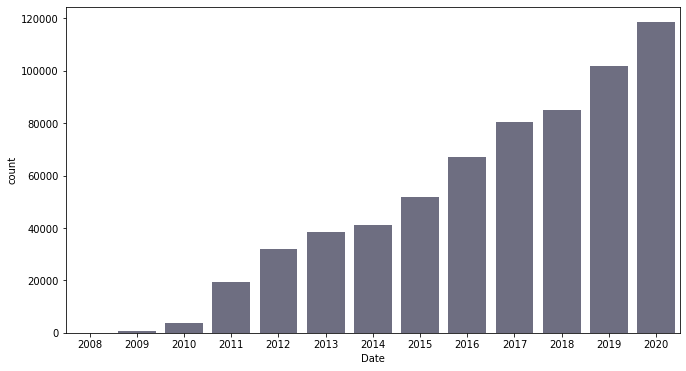

In [10]:
plt.figure(figsize=(11,6))
sns.countplot(all_tweets_df.Date.str[0:4] , color=(.42,.42,.52))

## TOPIC MODELING WITH LDA

In [11]:
all_tweets_df.text_tok

0         [harry, potter, cumple, años, hace, años, escr...
1         [2020, cambiar, logo, empresa, colores, arco, ...
2         [saboteado, votacion, dejando, debate, elimina...
3         [congresista, agradecio, organizaciones, viene...
4         [intervencion, debate, paridad, alternancia, i...
                                ...                        
639254         [mete, autogoles, cualquier, equipo, futbol]
639255                                       [correcaminos]
639256    [cuenta, fujitroll, busca, copiarse, francamen...
639257                                       [ayer, verdad]
639258    [tendencia, carla, garcia, consiguio, trabajo,...
Name: text_tok, Length: 639259, dtype: object

## Creamos bigramas y trigramas y los guardamos con *pickle*

In [12]:
%%time
serie_tmp=all_tweets_df.text_tok
bigram = gensim.models.Phrases(serie_tmp) #, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[serie_tmp]) #, threshold=100)  

# Una forma más rápida de conseguir trigrama/bigrama 
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

Wall time: 2min 19s


In [13]:
with open("gensim_bigram_model_Phraser.zip","wb") as f:
    pickle.dump(bigram_mod,f)
with open("gensim_trigram_model_Phraser.zip","wb") as f: 
    pickle.dump(trigram_mod,f)    

In [14]:
#bigram_mod = gensim.models.phrases.Phraser(bigram)
with open("gensim_bigram_model_Phraser.zip","rb") as f: 
    bigram_mod = pickle.load(f)
with open("gensim_trigram_model_Phraser.zip","rb") as f: 
    trigram_mod = pickle.load(f)  

In [228]:
orientacion='der'
serie_tmp=orientacion_tweets_df_dict[orientacion].text_prep.apply(lambda txt:txt.split())
for a in range(200):
    print(trigram_mod[serie_tmp[a]])

['alocucion', 'almirante_jorge', 'montoya', 'pocos', 'lideres', 'nacionales', 'habla', 'fuerte_claro', 'felicitaciones']
['cobarde', 'vizcarra', 'quejandose', 'exigen', 'resolver_problemas', 'vienen', 'gobiernos_pasados', 'diferencia']
['pueblo', 'decia', 'mismo', 'habia', 'escucharlo', 'cerraba', 'congreso']
['podria', 'quejarse', 'gobierno', 'totalitarios', 'destruyan', 'imagenes', 'colon', 'latinoamerica']
['especie', 'sexto', 'estilo', 'ágatha', 'dice', 'paridad_alternancia', 'desast']
['victor_zamora', 'deje', 'momento', 'pensar', 'sueldo', 'cobra', 'camarilla', 'asesores', 'izquierda']
['martin_vizcarra', 'camas', 'pasar', 'fines_junio', 'camas', 'segun', 'sala_situacional']
['marc', 'anthony', 'david', 'beckham', 'donaron', 'construccion', 'albergue', 'niños_cancer', 'peru']
['ayer', 'pdte', 'dijo', 'casi', 'gritando', 'perú', 'fracasado', 'cierto', 'sobrevive', 'gracias', 'propio', 'cuidado', 'caer']
['luego', 'meses', 'profugo', 'comunista', 'gregorio_santos', 'capturado', 'so

In [229]:
orientacion='izq'
serie_tmp=orientacion_tweets_df_dict[orientacion].text_prep.apply(lambda txt:txt.split())
for a in range(1200,1400):
    print(trigram_mod[serie_tmp[a]])

['votare', 'usted']
['pais', 'todas_sangres']
['realmente', 'gusta', 'claridad', 'simpleza', 'habla', 'muchas', 'izquierda', 'podrian']
['hecho', 'politica', 'negocio']
['ahora', 'mejor', 'debate', 'agenda_parlamentaria', '2020']
['gusto', 'escuchar', 'ojala', 'electo', 'lima']
['cochero', 'ingresar', 'congreso', 'necesitamos']
[]
['enrique_fernandez', 'debate', 'representante', 'nefasta', 'fujimontesinismo']
['enrique_fernandez', 'financiacion', 'partidos_politicos']
['retorno_bicameralidad', 'favor', 'respetar', 'dice', 'gente', 'prin']
['intervencion', 'rechaza', 'completamente', 'financiamiento', 'privados']
['bicameralidad', 'dice', 'personalmente', 'favor', 'respetar', 'voluntad_pueblo', 'expre']
['objetivo', 'empresa_privada', 'tendria', 'interes', 'colocar', 'dinero', 'partidos_politicos', 'congresistas', 'influ']
['enrique_fernandez', 'chacon', 'favor', 'bicameralidad']
['financiamiento_publico', 'solo', 'claro', 'sino', 'autentico']
['vivo', 'enrique_fernandez', 'frente_ampli

## WordCloud **por orientacion** removiendo las palabras mas comunes

In [70]:
#palabras comunes en politica y comunes en general
common_words = ['peru','gracias','solo','congreso', 'años','puede','gobierno','politica','estan','siempre','foto','nueva','hola','pais','debe',
                'hace','facebook','publique','ahora','estare','bien','tambien','cuenta', 'usted','creo','aqui','dice','gran','estan','vizcarra'
                'congresista','congresistas','peruano','mejor','toda','todo','buen','bueno','sera','cada','presidente','nadie','hacer','hilo','sino','mismo',
                'partido','caso','accion popular','keiko','apra','aprista','video lista','patria','roja','fuerza','popular','menos']

Orientacion:  cen 
Tokens original: 44401
Tokens para el wordcloud: 44361
Tokens mas comunes: [('', 3091), ('lima', 1415), ('toledo', 1078), ('justicia', 741), ('fiscal', 683), ('trabajo', 672), ('corrupcion', 625), ('personas', 601), ('vizcarra', 578), ('caso', 560), ('accion', 556), ('popular', 553), ('importante', 550), ('millones', 550), ('salud', 548), ('buena', 544), ('educacion', 539), ('dias', 532), ('muchas', 532), ('nacional', 530), ('poder', 528), ('favor', 518), ('jorge', 518), ('ministro', 515), ('tiempo', 514)]


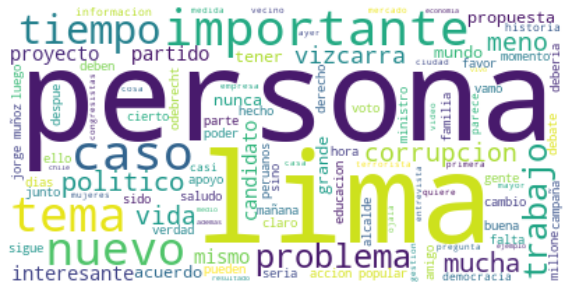

Orientacion:  cder 
Tokens original: 34716
Tokens para el wordcloud: 34676
Tokens mas comunes: [('señor', 1161), ('yurimaguas', 754), ('loreto', 632), ('', 569), ('alto', 563), ('vizcarra', 487), ('amazonas', 467), ('gente', 453), ('trabajo', 433), ('publicado', 415), ('excelente', 408), ('nacional', 400), ('proyecto', 378), ('tema', 371), ('salud', 370), ('poder', 358), ('lima', 354), ('comision', 352), ('muchas', 350), ('corrupcion', 349), ('peruanos', 344), ('acuerdo', 342), ('martin', 340), ('vida', 337), ('ministro', 332)]


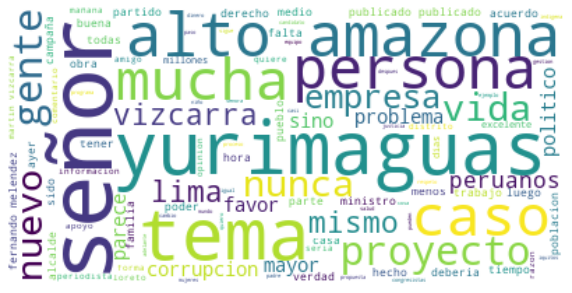

Orientacion:  izq 
Tokens original: 100251
Tokens para el wordcloud: 100211
Tokens mas comunes: [('', 11411), ('lima', 5210), ('mujeres', 4992), ('comision', 3741), ('corrupcion', 3545), ('justicia', 3461), ('derechos', 3360), ('violencia', 3056), ('frente', 2959), ('nacional', 2934), ('caso', 2909), ('vida', 2904), ('trabajo', 2874), ('gente', 2804), ('salud', 2752), ('vivo', 2713), ('nuevo', 2707), ('personas', 2548), ('lucha', 2502), ('trabajadores', 2401), ('mujer', 2387), ('mañana', 2374), ('dias', 2371), ('pueblo', 2349), ('congresistas', 2347)]


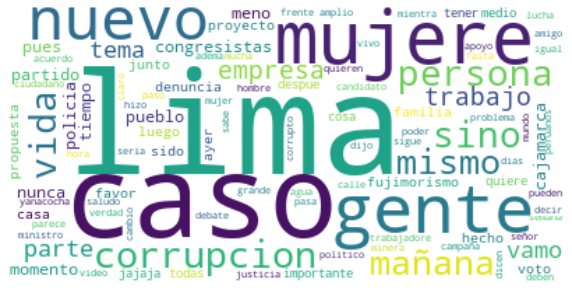

Orientacion:  cizq 
Tokens original: 12675
Tokens para el wordcloud: 12635
Tokens mas comunes: [('garcia', 198), ('caso', 173), ('comision', 150), ('', 138), ('odebrecht', 136), ('megacomision', 133), ('minutos', 131), ('keiko', 115), ('fiscal', 114), ('muchas', 110), ('feliz', 109), ('corrupcion', 108), ('nacional', 103), ('parece', 102), ('fujimorismo', 98), ('fujimori', 97), ('acuerdo', 96), ('fiscalia', 93), ('mañana', 88), ('alan', 88), ('radio', 88), ('articulo', 83), ('buena', 83), ('educacion', 81), ('dias', 79)]


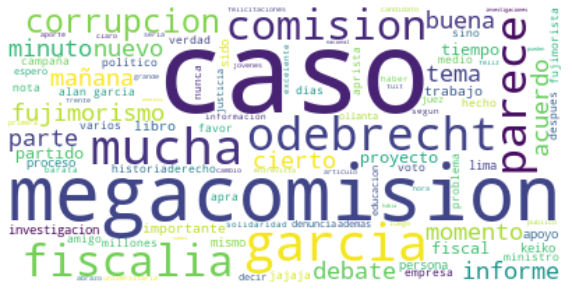

Orientacion:  der 
Tokens original: 106639
Tokens para el wordcloud: 106599
Tokens mas comunes: [('', 13927), ('vizcarra', 9537), ('comision', 6493), ('ministro', 6340), ('caso', 5773), ('humala', 5671), ('corrupcion', 5495), ('millones', 5442), ('keiko', 5317), ('salud', 5155), ('lima', 5075), ('fiscal', 5028), ('justicia', 4963), ('poder', 4913), ('trabajo', 4702), ('fujimori', 4400), ('nadine', 4395), ('odebrecht', 4326), ('peruanos', 4178), ('nacional', 4138), ('mismo', 3992), ('gente', 3969), ('vida', 3967), ('verdad', 3902), ('nunca', 3757)]


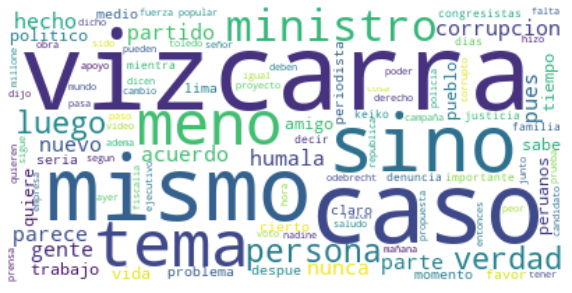

Orientacion:  nul 
Tokens original: 6050
Tokens para el wordcloud: 6010
Tokens mas comunes: [('', 221), ('amigo', 184), ('general', 148), ('amigos', 129), ('batallon', 128), ('cuente', 101), ('parece', 87), ('influencias', 85), ('keiko', 66), ('apoyo', 64), ('alguien', 62), ('favor', 61), ('claro', 59), ('entonces', 56), ('movere', 55), ('tema', 55), ('señorita', 52), ('despues', 51), ('ahijada', 51), ('vizcarra', 50), ('hizo', 49), ('señor', 48), ('maria', 48), ('fujitroll', 47), ('entiendo', 45)]


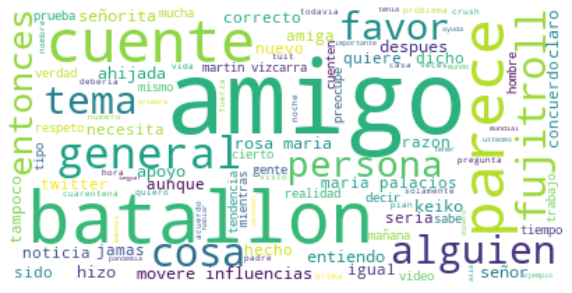

In [53]:
for orientacion in conjunto_orientacion: 
    text = ' '.join(orientacion_tweets_df_dict[orientacion].text_prep)
    c_tokens = Counter(text.split(' ')) 
    print("Orientacion: ",orientacion,"\nTokens original:",len(c_tokens))
    text = remove_common(text,common_words)
    c_tokens = Counter(text.split(' ')) 
    print("Tokens para el wordcloud:",len(c_tokens))
    print("Tokens mas comunes:",c_tokens.most_common(25))
    muestra_wordcloud(text)

## Word Cloud **por partido**, removiendo las palabras mas comunes

Partido:  ppc (partido popular cristiano)
Tokens original: 21841
Tokens para el wordcloud: 21791
Tokens mas comunes: [('', 508), ('ministro', 460), ('gente', 386), ('lima', 382), ('vizcarra', 364), ('ejecutivo', 351), ('peruanos', 342), ('corrupcion', 338), ('salud', 327), ('verdad', 320), ('todas', 309), ('pueblo', 305), ('tmbn', 299), ('poder', 281), ('claro', 275), ('tiempo', 273), ('poblacion', 268), ('dios', 266), ('justicia', 256), ('vida', 253), ('dias', 241), ('ministra', 240), ('ministros', 230), ('verguenza', 227), ('deben', 222)]


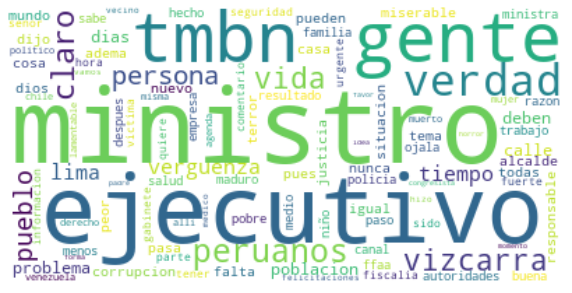

Partido:  pnp (partido ollanta)
Tokens original: 22971
Tokens para el wordcloud: 22920
Tokens mas comunes: [('', 817), ('mujer', 512), ('saludos', 499), ('pdte', 428), ('violencia', 419), ('dios', 378), ('vida', 323), ('personas', 257), ('trabajo', 256), ('mujeres', 250), ('salud', 235), ('señor', 226), ('casos', 222), ('nacional', 202), ('justicia', 200), ('lima', 193), ('familia', 193), ('atencion', 190), ('tema', 189), ('dias', 182), ('ministros', 181), ('ayer', 181), ('favor', 179), ('ministro', 174), ('muerte', 174)]


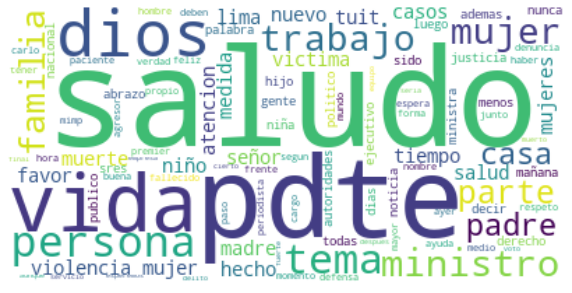

Partido:  fa (frente amplio)
Tokens original: 49744
Tokens para el wordcloud: 49693
Tokens mas comunes: [('corrupcion', 2188), ('comision', 1981), ('cajamarca', 1928), ('frente', 1747), ('agua', 1744), ('conga', 1608), ('lima', 1530), ('justicia', 1516), ('congresista', 1505), ('derechos', 1490), ('yanacocha', 1471), ('lucha', 1360), ('mineria', 1354), ('nacional', 1350), ('pueblo', 1225), ('trabajadores', 1211), ('', 1179), ('salud', 1165), ('mujeres', 1136), ('amplio', 1078), ('minera', 1032), ('empresas', 1013), ('poder', 975), ('proyecto', 938), ('trabajo', 921)]


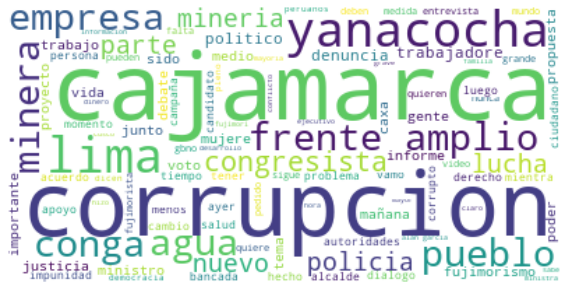

Partido:  mil (militar)
Tokens original: 17194
Tokens para el wordcloud: 17145
Tokens mas comunes: [('terrorismo', 272), ('corrupcion', 236), ('terroristas', 222), ('ffaa', 174), ('politicos', 162), ('nunca', 154), ('deben', 153), ('mundo', 153), ('cierto', 152), ('poder', 143), ('justicia', 134), ('buena', 133), ('pueden', 127), ('millones', 127), ('democracia', 126), ('tiempo', 122), ('venezuela', 120), ('terrorista', 117), ('chile', 117), ('seguridad', 116), ('problema', 115), ('vida', 114), ('politico', 114), ('ello', 111), ('deberia', 111)]


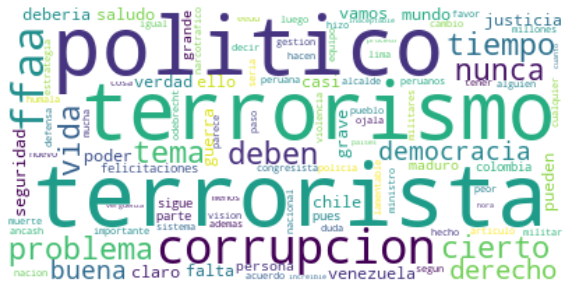

Partido:  psn (solidaridad nacional)
Tokens original: 28645
Tokens para el wordcloud: 28594
Tokens mas comunes: [('vizcarra', 914), ('odebrecht', 530), ('', 495), ('ministro', 461), ('millones', 447), ('nadine', 357), ('lima', 350), ('venezuela', 316), ('vida', 299), ('derecho', 295), ('razon', 291), ('salud', 288), ('acuerdo', 286), ('humala', 276), ('maduro', 275), ('peruanos', 273), ('menos', 269), ('trabajo', 269), ('nacional', 262), ('tema', 262), ('deben', 253), ('corrupcion', 252), ('articulo', 246), ('nuevo', 245), ('niños', 242)]


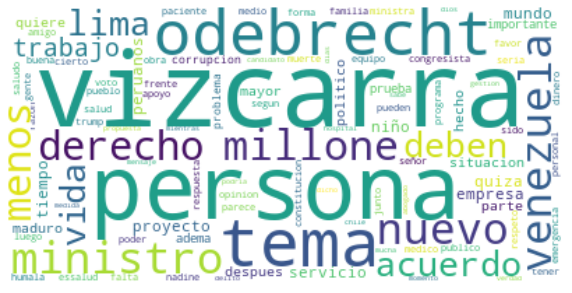

Partido:  per (periodista)
Tokens original: 469
Tokens para el wordcloud: 454
Tokens mas comunes: [('lima', 7), ('eielson', 6), ('museo', 6), ('coleccion', 4), ('world', 3), ('jorge', 3), ('farid', 3), ('ultimo', 3), ('artista', 3), ('argentino', 3), ('garcia', 3), ('pedidos', 2), ('sabado', 2), ('ayudar', 2), ('sido', 2), ('paises', 2), ('lavado', 2), ('abrazo', 2), ('fuerte', 2), ('equipo', 2), ('china', 2), ('maria', 2), ('editorial', 2), ('comercio', 2), ('paola', 2)]


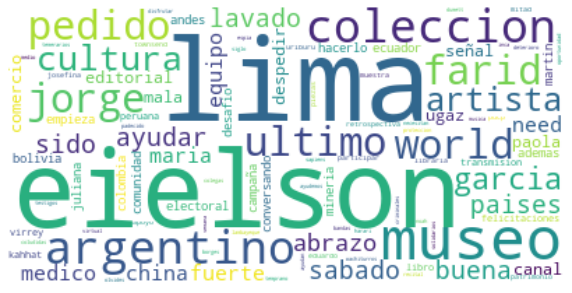

Partido:  mor (partido morado)
Tokens original: 11625
Tokens para el wordcloud: 11574
Tokens mas comunes: [('', 167), ('comision', 160), ('personas', 139), ('proyecto', 131), ('salud', 124), ('importante', 118), ('congresista', 109), ('trabajo', 106), ('mujeres', 91), ('muchas', 90), ('favor', 85), ('apoyo', 84), ('tema', 82), ('derechos', 80), ('gente', 79), ('bancada', 79), ('lucha', 77), ('violencia', 77), ('nuevo', 75), ('justicia', 74), ('voto', 73), ('dias', 73), ('pueden', 73), ('reforma', 69), ('familia', 68)]


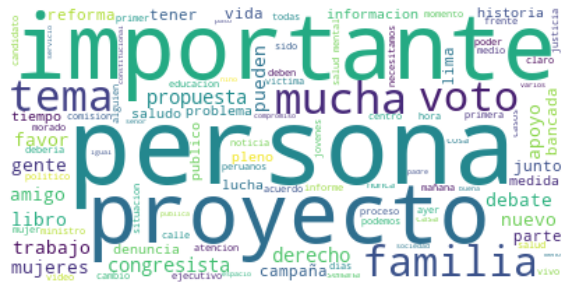

Partido:  pr (patraia roja)
Tokens original: 14552
Tokens para el wordcloud: 14502
Tokens mas comunes: [('', 333), ('comunista', 325), ('salud', 303), ('izquierda', 252), ('crisis', 239), ('pueblo', 234), ('trabajadores', 230), ('nacional', 220), ('lucha', 194), ('educacion', 189), ('frente', 188), ('millones', 175), ('lima', 171), ('derecha', 169), ('gente', 168), ('fujimori', 165), ('china', 164), ('mundo', 162), ('vida', 161), ('vamos', 147), ('corrupcion', 147), ('juntos', 143), ('pandemia', 137), ('eeuu', 132), ('derechos', 131)]


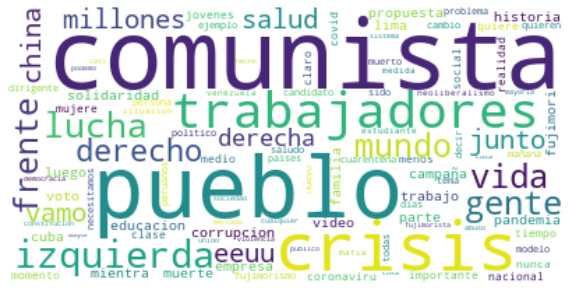

Partido:  fp (fuerza popular)
Tokens original: 68751
Tokens para el wordcloud: 68700
Tokens mas comunes: [('comision', 4519), ('', 4141), ('vizcarra', 3255), ('salud', 2995), ('congresista', 2654), ('fujimori', 2619), ('trabajo', 2601), ('corrupcion', 2546), ('justicia', 2519), ('nadine', 2513), ('fiscal', 2503), ('ministro', 2493), ('pdte', 2140), ('millones', 2117), ('nacional', 2077), ('odebrecht', 2052), ('sesion', 2003), ('constitucion', 1949), ('humala', 1949), ('toledo', 1911), ('poder', 1900), ('feliz', 1887), ('vida', 1824), ('peruanos', 1820), ('parte', 1573)]


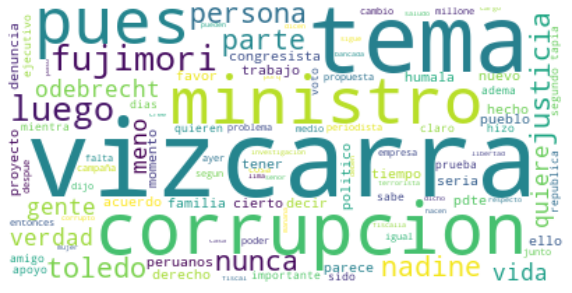

Partido:  apra (apra)
Tokens original: 27508
Tokens para el wordcloud: 27457
Tokens mas comunes: [('', 1183), ('vizcarra', 1031), ('entrevista', 872), ('alan', 861), ('millones', 816), ('programa', 705), ('garcia', 637), ('pueblo', 539), ('humala', 509), ('nota', 491), ('traves', 464), ('canal', 437), ('ministro', 435), ('nacional', 427), ('lima', 392), ('diario', 361), ('nunca', 356), ('comision', 348), ('justicia', 339), ('articulo', 336), ('fiscal', 330), ('peruanos', 325), ('corrupcion', 317), ('aprismo', 313), ('alianza', 307)]


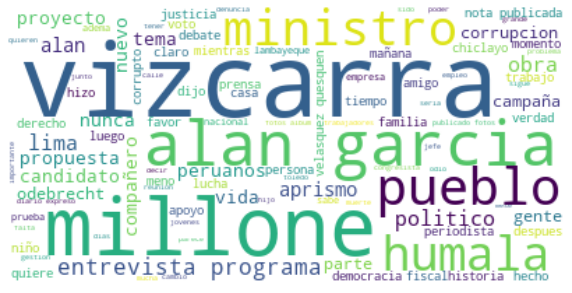

Partido:  app (alianza para el progreso)
Tokens original: 33289
Tokens para el wordcloud: 33238
Tokens mas comunes: [('humala', 945), ('yurimaguas', 753), ('juan', 742), ('ministro', 667), ('comision', 659), ('lima', 637), ('loreto', 630), ('alto', 611), ('vizcarra', 603), ('entrevista', 599), ('garcia', 545), ('nacional', 541), ('pastor', 520), ('', 518), ('sheput', 515), ('mate', 507), ('trabajo', 497), ('amazonas', 479), ('nuevo', 466), ('corrupcion', 449), ('publicado', 430), ('proyecto', 424), ('columna', 421), ('video', 420), ('debate', 413)]


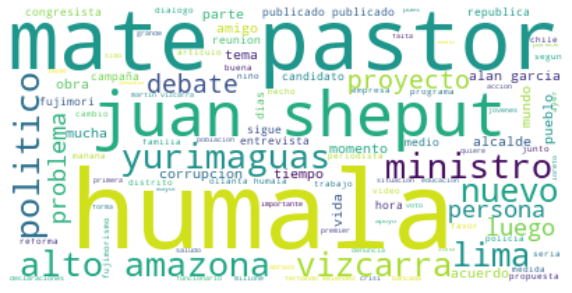

Partido:  upp (union por el peru)
Tokens original: 8315
Tokens para el wordcloud: 8266
Tokens mas comunes: [('', 412), ('ministro', 376), ('video', 287), ('comision', 237), ('justicia', 195), ('lista', 155), ('nacional', 153), ('añadido', 147), ('reproduccion', 147), ('educacion', 141), ('derechos', 138), ('sesion', 127), ('trabajo', 126), ('humanos', 123), ('universidades', 121), ('pleno', 120), ('reforma', 120), ('zeballos', 118), ('reunion', 111), ('vicente', 108), ('titular', 100), ('fecha', 99), ('congresista', 94), ('nota', 94), ('intervencion', 83)]


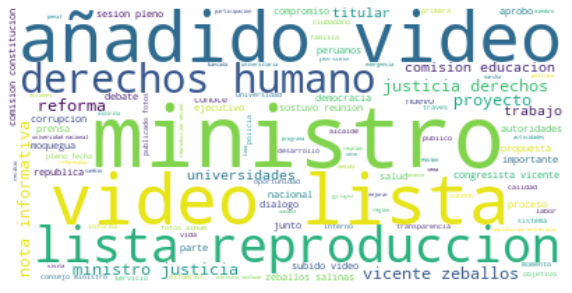

Partido:  pp (podemos peru)
Tokens original: 19442
Tokens para el wordcloud: 19391
Tokens mas comunes: [('', 1359), ('urresti', 742), ('olivos', 430), ('fiscal', 408), ('alan', 355), ('verdad', 282), ('lima', 262), ('daniel', 261), ('pruebas', 252), ('trabajo', 219), ('gente', 215), ('despues', 213), ('seguridad', 211), ('delincuentes', 207), ('vecinos', 200), ('nunca', 197), ('alguien', 191), ('alcalde', 183), ('quiere', 181), ('favor', 180), ('cierto', 179), ('juicio', 178), ('corrupcion', 177), ('vida', 176), ('sabe', 175)]


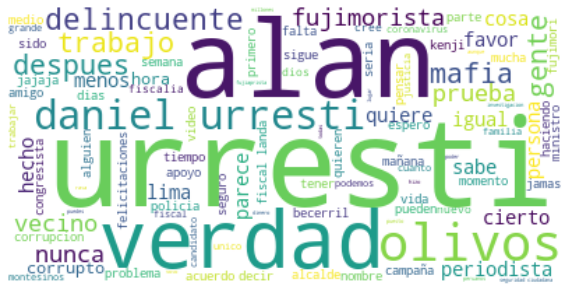

Partido:  ppk (peruanos por el kambio)
Tokens original: 12419
Tokens para el wordcloud: 12368
Tokens mas comunes: [('comision', 184), ('peruanos', 157), ('trabajo', 152), ('reforma', 133), ('millones', 131), ('justicia', 127), ('vizcarra', 123), ('', 116), ('parlamento', 116), ('corrupcion', 111), ('democracia', 109), ('nuevo', 104), ('agua', 104), ('mundo', 101), ('ministro', 98), ('ejecutivo', 98), ('nacional', 97), ('debate', 96), ('violeta', 95), ('congresista', 94), ('sistema', 93), ('proyecto', 89), ('vamos', 89), ('economia', 88), ('pueblo', 88)]


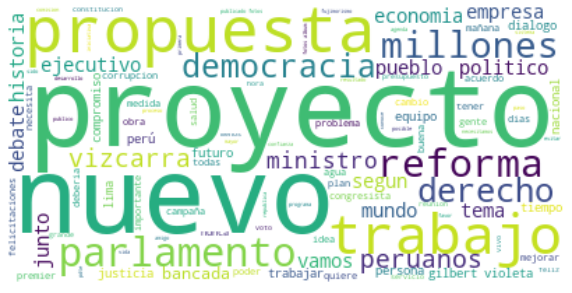

Partido:  PPP (peru posible)
Tokens original: 15283
Tokens para el wordcloud: 15232
Tokens mas comunes: [('', 1208), ('toledo', 986), ('fiscal', 449), ('justicia', 406), ('maiman', 317), ('reconoce', 274), ('persecución', 256), ('proceso', 254), ('ecoteva', 249), ('perú', 245), ('política', 238), ('debido', 234), ('guillen', 224), ('avelino', 220), ('prestigioso', 216), ('pueblo', 193), ('dueño', 170), ('peruana', 168), ('judicial', 145), ('defensa', 137), ('eeuu', 137), ('hizo', 136), ('mafia', 135), ('favor', 135), ('violaciones', 133)]


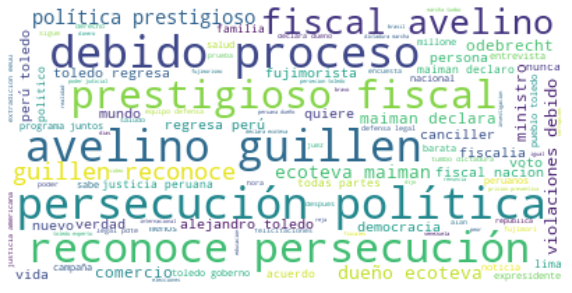

Partido:  np (nuevo peru)
Tokens original: 28586
Tokens para el wordcloud: 28535
Tokens mas comunes: [('lima', 1189), ('mujeres', 856), ('', 844), ('congresista', 798), ('comision', 761), ('corrupcion', 641), ('trabajadores', 639), ('video', 609), ('violencia', 597), ('trabajo', 591), ('nuevo', 587), ('derechos', 523), ('vamos', 506), ('justicia', 501), ('transporte', 499), ('fujimorismo', 479), ('proyecto', 478), ('gente', 462), ('nacional', 460), ('publico', 423), ('lucha', 421), ('frente', 407), ('dias', 397), ('vida', 390), ('mañana', 389)]


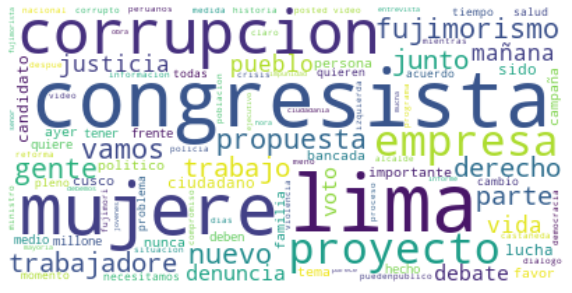

Partido:  nul (no conocido)
Tokens original: 99147
Tokens para el wordcloud: 99096
Tokens mas comunes: [('', 15294), ('vizcarra', 5059), ('lima', 4026), ('mujeres', 3284), ('gente', 3253), ('poder', 2875), ('parece', 2556), ('menos', 2530), ('justicia', 2526), ('ministro', 2505), ('dias', 2500), ('vida', 2476), ('vivo', 2450), ('personas', 2412), ('nunca', 2367), ('corrupcion', 2293), ('nuevo', 2293), ('señor', 2281), ('acuerdo', 2278), ('millones', 2277), ('claro', 2237), ('humala', 2197), ('verdad', 2172), ('pues', 2157), ('trabajo', 2136)]


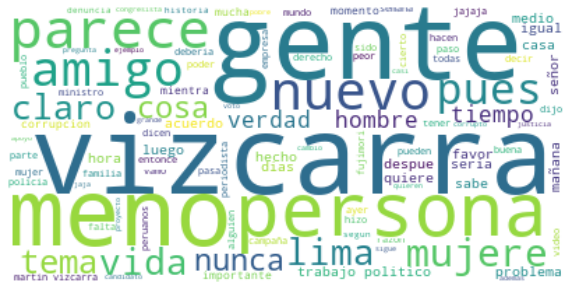

Partido:  ap (accion popular)
Tokens original: 23562
Tokens para el wordcloud: 23511
Tokens mas comunes: [('lima', 1127), ('', 707), ('accion', 489), ('muñoz', 487), ('alcalde', 447), ('jorge', 433), ('vecinos', 379), ('propuestas', 374), ('adelante', 359), ('candidato', 353), ('ciudad', 326), ('mañana', 321), ('campaña', 315), ('elecciones', 307), ('seguridad', 299), ('apoyo', 298), ('voto', 298), ('miraflores', 275), ('debate', 275), ('trabajo', 272), ('vivo', 272), ('entrevista', 265), ('muchas', 261), ('gestion', 248), ('vamos', 248)]


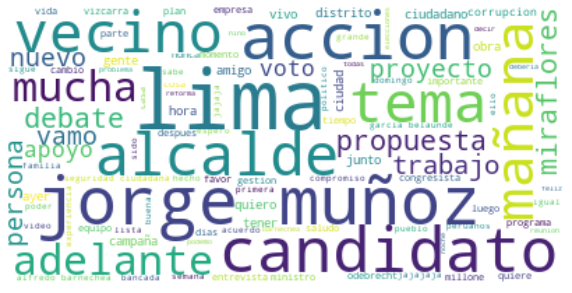

In [69]:
for partido in conjunto_partidos:     
    df=partidosdf_dict[partido]
    nombre_partido = df.nombre_partido.iloc[0]
    text = ' '.join(partidos_tweets_df_dict[partido].text_prep)
    c_tokens = Counter(text.split(' ')) 
    print("Partido: ",partido,f"({nombre_partido})\nTokens original:",len(c_tokens))
    text = remove_common(text,common_words)
    c_tokens = Counter(text.split(' ')) 
    print("Tokens para el wordcloud:",len(c_tokens))
    print("Tokens mas comunes:",c_tokens.most_common(25))
    muestra_wordcloud(text)

# ----------------------------------------------------------------------------

## TOPIC MODELING WITH LDA

In [84]:
orientacion='izq'

serie_tmp=orientacion_tweets_df_dict[orientacion].text_prep.apply(lambda txt:word_tokenize(txt))

dictionary = corpora.Dictionary(serie_tmp)
corpus = [dictionary.doc2bow(text) for text in  serie_tmp]

In [85]:

NUM_TOPICS = 5

ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
topics = ldamodel.print_topics(num_words=9)

for topic in topics:
    print(topic)

(0, '0.014*"frente" + 0.013*"peru" + 0.012*"gracias" + 0.012*"amplio"')
(1, '0.011*"fujimori" + 0.008*"agua" + 0.008*"cada" + 0.007*"publica"')
(2, '0.009*"fujimorismo" + 0.007*"solo" + 0.007*"hace" + 0.006*"bien"')
(3, '0.009*"salud" + 0.009*"trabajadores" + 0.008*"pais" + 0.008*"derechos"')
(4, '0.017*"congreso" + 0.016*"comision" + 0.015*"congresista" + 0.009*"debe"')


In [87]:
topics = ldamodel.print_topics(num_words=9)

for topic in topics:
    print(topic)

(0, '0.014*"frente" + 0.013*"peru" + 0.012*"gracias" + 0.012*"amplio" + 0.010*"lima" + 0.007*"vamos" + 0.006*"izquierda" + 0.006*"lucha" + 0.005*"gran"')
(1, '0.011*"fujimori" + 0.008*"agua" + 0.008*"cada" + 0.007*"publica" + 0.007*"keiko" + 0.007*"arana" + 0.007*"posted" + 0.005*"region" + 0.005*"pedro"')
(2, '0.009*"fujimorismo" + 0.007*"solo" + 0.007*"hace" + 0.006*"bien" + 0.005*"puede" + 0.005*"gente" + 0.005*"millones" + 0.005*"ahora" + 0.004*"tambien"')
(3, '0.009*"salud" + 0.009*"trabajadores" + 0.008*"pais" + 0.008*"derechos" + 0.007*"peru" + 0.006*"gobierno" + 0.006*"educacion" + 0.006*"ayacucho" + 0.005*"nacional"')
(4, '0.017*"congreso" + 0.016*"comision" + 0.015*"congresista" + 0.009*"debe" + 0.008*"presidente" + 0.007*"proyecto" + 0.007*"congresistas" + 0.007*"facebook" + 0.006*"corrupcion"')


### **4. Visualización con pyLDAvis**

In [81]:
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [94]:
list_y=list(orientacion_tweets_df_dict['der'].Date.str[0:4].unique())

In [95]:
list_y

['2020',
 '2019',
 '2018',
 '2017',
 '2016',
 '2015',
 '2014',
 '2013',
 '2012',
 '2011',
 '2010',
 '2009']

In [99]:
year_list = list(df_tweets_all.Date.str[0:4].unique())
year_tweets_df_dict = {}
for year in year_list:
    year_tweets_df_dict[year]=df_tweets_all.loc[df_tweets_all.Date.str[0:4]==year]


In [103]:
year_tweets_df_dict['2020']

index                   id             User  \
0           0  1276498807442804736  AlbertoBelaunde   
1           1  1276493803298476035  AlbertoBelaunde   
2           2  1276309117142020098  AlbertoBelaunde   
3           3  1276253647257690125  AlbertoBelaunde   
4           4  1276233710917074945  AlbertoBelaunde   
...       ...                  ...              ...   
639254   3222  1269709809709920257  GeneralDelAire1   
639255   3223  1269708522515828736  GeneralDelAire1   
639256   3224  1269700742400663557  GeneralDelAire1   
639257   3225  1269699810568929280  GeneralDelAire1   
639258   3226  1269699099114328066  GeneralDelAire1   

                                                     Text       Date  \
0       Harry Potter cumple 23 años. Hace unos años es...  2020-6-26   
1       RT @MMissCupcakes: En el 2020 cambiar el logo ...  2020-6-26   
2       RT @partidomorado: Hoy se ha saboteado la vota...  2020-6-26   
3       RT @ManuelaRamos: ➡️💪Congresista @AlbertoBelau...  2020-6-25   
4       Intervención en el debate de paridad y alterna...  2020-6-25   
...                                                   ...        ...   
639254  @geraldinearu Ella se mete más autogoles que c...   2020-6-7   
639255               @mundoperplejo Como el correcaminos.   2020-6-7   
639256  @gr0undzero1 @HateDispenser @aaleexxxxxxxx @on...   2020-6-7   
639257                    @AngryMan87 El de ayer, verdad.   2020-6-7   
639258  ¿Por qué está de tendencia Carla García?\n\n¿Y...   2020-6-7   

        Retweets                                      Mentions  \
0              6                                                 
1             15                                @MMissCupcakes   
2             40                                @partidomorado   
3              6                @ManuelaRamos @AlbertoBelaunde   
4             25                                                 
...          ...                                           ...   
639254         0                                 @geraldinearu   
639255         0                                @mundoperplejo   
639256         0  @gr0undzero1 @HateDispenser @onvres_explican   
639257         1                                   @AngryMan87   
639258        24                                                 

                         HashTags  \
0       #HarryPotter23 #Ravenclaw   
1                                   
2            #ParidadYAlternancia   
3            #ParidadYAlternancia   
4                                   
...                           ...   
639254                              
639255                              
639256                              
639257                              
639258                              

                                                text_prep Orientacion  
0       harry potter cumple años hace años escribi tex...         cen  
1       2020 cambiar logo empresa colores arco iris va...         cen  
2       saboteado votacion dejando debate eliminacion ...         cen  
3       congresista agradecio organizaciones vienen pe...         cen  
4       intervencion debate paridad alternancia import...         cen  
...                                                   ...         ...  
639254             mete autogoles cualquier equipo futbol         nul  
639255                                       correcaminos         nul  
639256  cuenta fujitroll busca copiarse francamente ha...         nul  
639257                                        ayer verdad         nul  
639258  tendencia carla garcia consiguio trabajo mujer...         nul  

[118526 rows x 10 columns]

In [104]:
%%time
orientacion='izq'
serie_tmp=orientacion_tweets_df_dict[orientacion].text_prep.apply(lambda txt:word_tokenize(txt))
bigram = gensim.models.Phrases(serie_tmp, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[serie_tmp], threshold=100)  

# Una forma más rápida de conseguir trigrama/bigrama 
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [127]:
orientacion='der'
serie_tmp=orientacion_tweets_df_dict[orientacion].text_prep.apply(lambda txt:word_tokenize(txt))
for a in range(200):
    print(bigram[serie_tmp[a]])

['alocucion', 'almirante', 'jorge', 'montoya', 'pocos', 'lideres', 'nacionales', 'habla', 'fuerte', 'claro', 'felicitaciones']
['cobarde', 'vizcarra', 'quejandose', 'exigen', 'resolver_problemas', 'vienen', 'gobiernos', 'pasados', 'diferencia']
['pueblo', 'decia', 'mismo', 'habia', 'escucharlo', 'cerraba', 'congreso']
['podria', 'quejarse', 'gobierno', 'totalitarios', 'destruyan', 'imagenes', 'colon', 'latinoamerica']
['especie', 'sexto', 'estilo', 'ágatha', 'dice', 'paridad_alternancia', 'desast']
['victor_zamora', 'deje', 'momento', 'pensar', 'sueldo', 'cobra', 'camarilla', 'asesores', 'izquierda']
['martin_vizcarra', 'camas', 'pasar', 'fines', 'junio', 'camas', 'segun', 'sala', 'situacional']
['marc', 'anthony', 'david', 'beckham', 'donaron', 'construccion', 'albergue', 'niños', 'cancer', 'peru']
['ayer', 'pdte', 'dijo', 'casi', 'gritando', 'perú', 'fracasado', 'cierto', 'sobrevive', 'gracias', 'propio', 'cuidado', 'caer']
['luego', 'meses', 'profugo', 'comunista', 'gregorio_santos'

In [ ]:
    

#c_tokens = Counter(politicotweets_all.split(' ')) 
#print(len(c_tokens))
#c_tokens.most_common(15)
politicotweets_all = ' '.join(df_series_text_prep)
    
for idx,scr_name in enumerate(politicosdb_df['screen_name']): 
    df=politicosdf_dict[scr_name[1:]]
    print("Usuario: ",scr_name," / ",politicosdb_df['nombre'].iloc[idx]," / ",politicosdb_df['nombre_partido'].iloc[idx])
    muestra_wordcloud(df.text_prep)

In [104]:
%%time
orientacion='izq'
serie_tmp=orientacion_tweets_df_dict[orientacion].text_prep.apply(lambda txt:txt.split())
bigram = gensim.models.Phrases(serie_tmp, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[serie_tmp], threshold=100)  

# Una forma más rápida de conseguir trigrama/bigrama 
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [127]:
orientacion='der'
serie_tmp=orientacion_tweets_df_dict[orientacion].text_prep.apply(lambda txt:txt.split())
for a in range(200):
    print(bigram[serie_tmp[a]])

['alocucion', 'almirante', 'jorge', 'montoya', 'pocos', 'lideres', 'nacionales', 'habla', 'fuerte', 'claro', 'felicitaciones']
['cobarde', 'vizcarra', 'quejandose', 'exigen', 'resolver_problemas', 'vienen', 'gobiernos', 'pasados', 'diferencia']
['pueblo', 'decia', 'mismo', 'habia', 'escucharlo', 'cerraba', 'congreso']
['podria', 'quejarse', 'gobierno', 'totalitarios', 'destruyan', 'imagenes', 'colon', 'latinoamerica']
['especie', 'sexto', 'estilo', 'ágatha', 'dice', 'paridad_alternancia', 'desast']
['victor_zamora', 'deje', 'momento', 'pensar', 'sueldo', 'cobra', 'camarilla', 'asesores', 'izquierda']
['martin_vizcarra', 'camas', 'pasar', 'fines', 'junio', 'camas', 'segun', 'sala', 'situacional']
['marc', 'anthony', 'david', 'beckham', 'donaron', 'construccion', 'albergue', 'niños', 'cancer', 'peru']
['ayer', 'pdte', 'dijo', 'casi', 'gritando', 'perú', 'fracasado', 'cierto', 'sobrevive', 'gracias', 'propio', 'cuidado', 'caer']
['luego', 'meses', 'profugo', 'comunista', 'gregorio_santos'

In [230]:
serie_tmp=all_tweets_db.text_tok

dictionary = corpora.Dictionary(serie_tmp)
corpus = [dictionary.doc2bow(text) for text in  serie_tmp]

In [377]:
def evaluate_graph(dictionary, corpus, texts, limit):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v



D:\Anaconda3\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
D:\Anaconda3\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


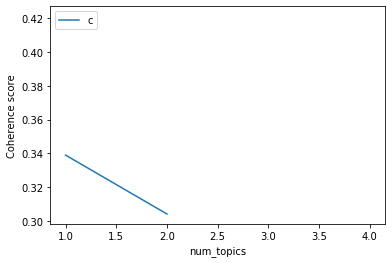

Wall time: 17min 48s


In [423]:
%%time
lmlist, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=serie_tmp, limit=20)

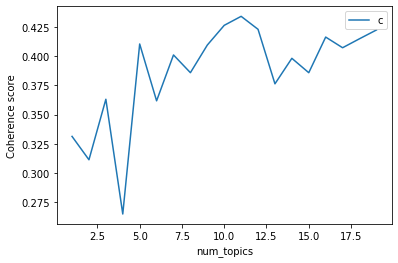

cen	

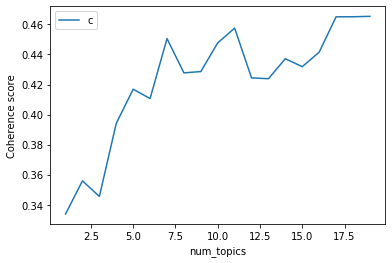

cder	

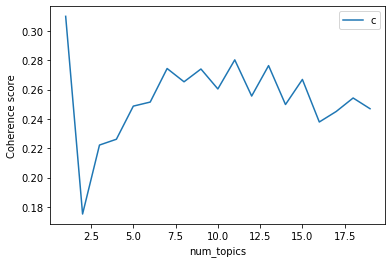

izq	

D:\Anaconda3\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
D:\Anaconda3\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


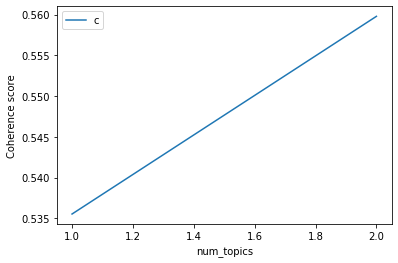

cizq	

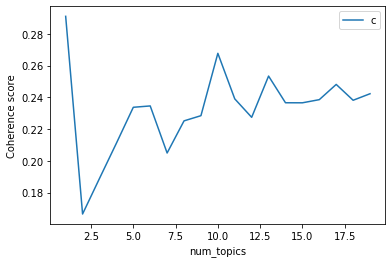

der	

D:\Anaconda3\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
D:\Anaconda3\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


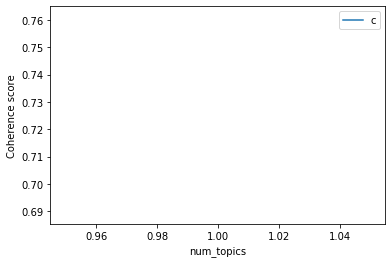

nul	Wall time: 1h 47min 36s


In [424]:
%%time
lista_cv = []
for orientacion in conjunto_orientacion:
    serie_tmp=all_tweets_df.loc[all_tweets_df.Orientacion==orientacion].text_tok
    lmlist2, c_v2 = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=serie_tmp, limit=20)
    lista_cv.append( [orientacion,lmlist2, c_v2 ] )
    print(orientacion, end="\t")

D:\Anaconda3\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
D:\Anaconda3\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


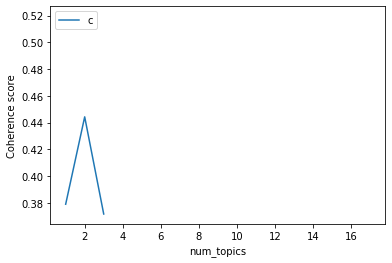

ppc	

D:\Anaconda3\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
D:\Anaconda3\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


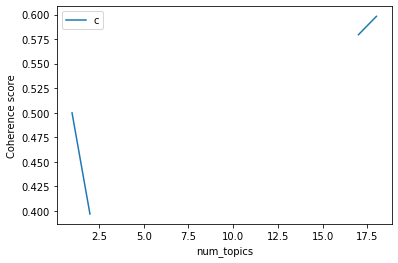

pnp	

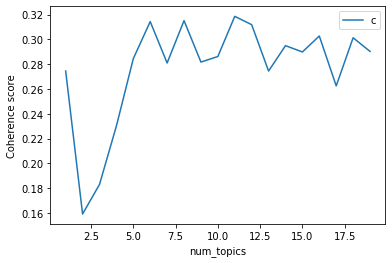

fa	

D:\Anaconda3\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
D:\Anaconda3\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


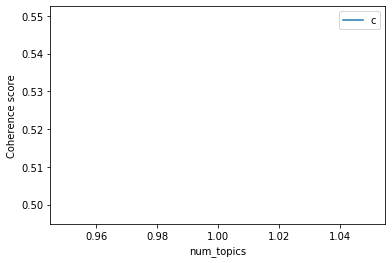

mil	

KeyboardInterrupt: 

In [425]:
%%time
lista_cv2 = []
for partido in conjunto_partidos:
    serie_tmp=all_tweets_df.loc[all_tweets_df.partido==partido].text_tok
    lmlist2, c_v2 = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=serie_tmp, limit=20)
    lista_cv2.append( [orientacion,lmlist2, c_v2 ] )
    print(partido, end="\t")

In [426]:
import pickle

In [85]:

NUM_TOPICS = 10

serie_tmp=all_tweets_db.text_tok

dictionary = corpora.Dictionary(serie_tmp)
corpus = [dictionary.doc2bow(text) for text in  serie_tmp]

ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
topics = ldamodel.print_topics(num_words=9)

for topic in topics:
    print(topic)

(0, '0.014*"frente" + 0.013*"peru" + 0.012*"gracias" + 0.012*"amplio"')
(1, '0.011*"fujimori" + 0.008*"agua" + 0.008*"cada" + 0.007*"publica"')
(2, '0.009*"fujimorismo" + 0.007*"solo" + 0.007*"hace" + 0.006*"bien"')
(3, '0.009*"salud" + 0.009*"trabajadores" + 0.008*"pais" + 0.008*"derechos"')
(4, '0.017*"congreso" + 0.016*"comision" + 0.015*"congresista" + 0.009*"debe"')


In [87]:
topics = ldamodel.print_topics(num_words=9)

for topic in topics:
    print(topic)

(0, '0.014*"frente" + 0.013*"peru" + 0.012*"gracias" + 0.012*"amplio" + 0.010*"lima" + 0.007*"vamos" + 0.006*"izquierda" + 0.006*"lucha" + 0.005*"gran"')
(1, '0.011*"fujimori" + 0.008*"agua" + 0.008*"cada" + 0.007*"publica" + 0.007*"keiko" + 0.007*"arana" + 0.007*"posted" + 0.005*"region" + 0.005*"pedro"')
(2, '0.009*"fujimorismo" + 0.007*"solo" + 0.007*"hace" + 0.006*"bien" + 0.005*"puede" + 0.005*"gente" + 0.005*"millones" + 0.005*"ahora" + 0.004*"tambien"')
(3, '0.009*"salud" + 0.009*"trabajadores" + 0.008*"pais" + 0.008*"derechos" + 0.007*"peru" + 0.006*"gobierno" + 0.006*"educacion" + 0.006*"ayacucho" + 0.005*"nacional"')
(4, '0.017*"congreso" + 0.016*"comision" + 0.015*"congresista" + 0.009*"debe" + 0.008*"presidente" + 0.007*"proyecto" + 0.007*"congresistas" + 0.007*"facebook" + 0.006*"corrupcion"')


### **4. Visualización con pyLDAvis**

In [81]:
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [ ]:
    

#c_tokens = Counter(politicotweets_all.split()) 
#print(len(c_tokens))
#c_tokens.most_common(15)
politicotweets_all = ' '.join(df_series_text_prep)
    
for idx,scr_name in enumerate(politicosdb_df['screen_name']): 
    df=politicosdf_dict[scr_name[1:]]
    print("Usuario: ",scr_name," / ",politicosdb_df['nombre'].iloc[idx]," / ",politicosdb_df['nombre_partido'].iloc[idx])
    muestra_wordcloud(df.text_prep)